Door Dennis Besselsen, Levi Verhoef, Emiel Verhoef (geen familie!)
V2A, 2021 

We beginnen met het importeren van een aantal libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.stats import pearsonr
from scipy.stats import stats

Hier lezen we onze beide databases alvast in:

In [2]:
#the film database from the assignment
table = pd.read_csv("movie.csv")

#film database we found online(https://www.kaggle.com/stefanoleone992/imdb-extensive-dataset)
table2 =  pd.read_csv("IMDB_movies.csv")

c:\users\leviv\onedrive - stichting hogeschool utrecht\hbo-ict\jaar 2\periode a\computational modeling\venv\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<h2>Onderzoeksvragen:</h2>

1. In hoeverre is de omzet van een film te voorspellen op basis van de populariteit op Facebook en IMDB?
2. In hoeverre is de IMDB score van een film te voorspellen op basis van het budget en de opbrengst?
3. Kunnen we logische klusters vinden van regisseurs die winstgevende films maken of regisseurs die vaak verliesgevende films maken?

<h1> Featurevariabelen: </h1>
We hebben een aantal featurevariabelen gekozen die passen bij onze onderzoeksvragen. Het zou altijd nog kunnen dat we bepaalde variabelen toevoegen of weglaten, maar dit is onze eerste selectie.

**director_name**: een **nominale meetwaarde** waarin de naam van de regisseur staat.
Director name heeft af en toe geen ingevulde waarde. Dat maakt voor onze onderzoeksvragen niet veel uit.

**num_voted_users**: een **discrete meetwaarde** die ons laat zien hoeveel mensen op een film hebben gestemd op IMDb.
Deze featurevariabele gebruiken we als één van onze maatstaven voor IMDb populariteit. Hoe meer mensen stemmen op een film, hoe hoger de populariteit. 
Dit is direct een handige variabele voor onze eerste onderzoeksvraag. 

**num_critic_for_reviews**: een **discrete meetwaarde** die ons laat zien hoeveel critici een film hebben gerecenseerd.
Deze featurevariabele is een andere maatstaf voor populariteit van een film op IMDb. Ook deze variabele lijkt op eerste oogopslag erg interessant voor onderzoeksvraag 1.

**num_user_for_reviews**: een **discrete meetwaarde** die ons laat zien hoeveel IMDb gebruikers een film hebben gerecenseerd.
Dit is de derde meetwaarde die IMDb populariteit aangeeft. Een review achterlaten is meer moeite dan simpelweg stemmen, 
dus wellicht dat de waardes voor deze featurevariabele zwaarder wegen of een sterkere correlatie aangeven dan de voorgaande variabelen die te maken hadden met IMDb populariteit.

**imdb_score**: een **discrete meetwaarde** die de score van een film weergeeft.
IMDB score is één van onze targetvariabelen en zodoende nemen we deze sowieso mee in onze dataset.

**movie_facebook_likes**: een **discrete meetwaarde** die de hoeveelheid likes die een film op facebook heeft weergeeft.
Movie_facebook_likes is de meetwaarde die we gebruiken om te bepalen hoe populair een film op facebook is, wat één van onze directe featurevariabelen is voor onderzoeksvraag 1.

**budget**: een **continue meetwaarde** die aangeeft hoeveel geld er is besteed aan het produceren van een film.
Budget is een meetwaarde die we sowieso interessant vonden om mee te nemen, eventueel voor onderzoeksvraag 2. 
We kwamen er al snel achter dat er een paar vreemde uitschieteres zijn, maar die zijn vrij simpel te verhelpen. Verder zullen we hier ook nog de waardes moeten normaliseren, gezien er af en toe waardes tussen zitten die in een andere munteenheid
Er zijn best veel entries in onze dataframe met null-waardes op "budget", dus we kiezen ervoor om die te droppen, gezien we deze featurevariabele centraal stellen in onze onderzoeksvraag.

**gross**: een **continue meetwaarde** die aangeeft hoeveel omzet een film heeft gedraaid.
Gross is een meetwaarde die in meerdere van onze onderzoeksvragen een vrij prominente rol speelt. 

<h2> Eerste kijk in de database met gekozen feature variabelen </h2>:

We gebruiken hier describe() om inzicht te krijgen in de centrum en spreidingsmaten van onze gekozen variabelen.

In [3]:
#trim tables so we only have feature variables
feature_table = table[['movie_title','duration', 'movie_imdb_link', 'num_voted_users', 'num_critic_for_reviews', 'num_user_for_reviews','imdb_score', 'movie_facebook_likes','budget', 'gross', 'director_name']]

# change the movie_imdb_link to a imdb_title_id
feature_table["movie_imdb_link"]= feature_table["movie_imdb_link"].str.split("/", n = 5, expand = True)[4]
feature_table = feature_table.rename(columns={"movie_imdb_link": "imdb_title_id"})

# Use describe function to show the central tendency and dispersion values, of only the feature variables
feature_table.describe()


C:\Users\LeviV\AppData\Local\Temp/ipykernel_17664/3742555808.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_table["movie_imdb_link"]= feature_table["movie_imdb_link"].str.split("/", n = 5, expand = True)[4]


,duration,num_voted_users,num_critic_for_reviews,num_user_for_reviews,imdb_score,movie_facebook_likes,budget,gross
count,5028.000000,5.043000e+03,4993.000000,5022.000000,5043.000000,5043.000000,4.551000e+03,4.159000e+03
mean,107.201074,8.366816e+04,140.194272,272.770808,6.442138,7525.964505,3.975262e+07,4.846841e+07
std,25.197441,1.384853e+05,121.601675,377.982886,1.125116,19320.445110,2.061149e+08,6.845299e+07
min,7.000000,5.000000e+00,1.000000,1.000000,1.600000,0.000000,2.180000e+02,1.620000e+02
25%,93.000000,8.593500e+03,50.000000,65.000000,5.800000,0.000000,6.000000e+06,5.340988e+06
50%,103.000000,3.435900e+04,110.000000,156.000000,6.600000,166.000000,2.000000e+07,2.551750e+07
75%,118.000000,9.630900e+04,195.000000,326.000000,7.200000,3000.000000,4.500000e+07,6.230944e+07
max,511.000000,1.689764e+06,813.000000,5060.000000,9.500000,349000.000000,1.221550e+10,7.605058e+08


Een aantal observaties:
    
We hebben ~5000 films in onze eerste database. 

De budget feature mist ~10% van zijn waardes, de gross feature bijna 20%.

Alle andere features missen maar een heel klein deel van hun waardes.

In [4]:
print(f'Voordat we de null-waardes droppen hebben we: {len(feature_table)} films in de database')

# Show the amount of NaN per column
print(feature_table.isnull().sum())

#drop all rows which containt atleast 1 NaN
feature_table.dropna(inplace=True)

#Print the amount of NaN's per column, which will be 0 after the previous dropna function
print(f'Nadat we de null-waardes droppen hebben we: {len(feature_table)} films in de database')



Voordat we de null-waardes droppen hebben we: 5043 films in de database
movie_title                 0
duration                   15
imdb_title_id               0
num_voted_users             0
num_critic_for_reviews     50
num_user_for_reviews       21
imdb_score                  0
movie_facebook_likes        0
budget                    492
gross                     884
director_name             104
dtype: int64
Nadat we de null-waardes droppen hebben we: 3889 films in de database


Hier verwijderen we alle films uit de dataframe met NaN waardes op onze gekozen featurevariabelen. Dit verwijdert **1154** films.

Gezien gross en budget hele belangrijke featurevariabelen zijn voor ons, en het eigenlijk te veel data is om genormaliseerde waardes in te vullen, hebben we ervoor gekozen om deze records simpelweg weg te laten.

We verwijderen wellicht ook een aantal rijen vanwege andere ontbrekende variabelen, maar dat zijn er relatief weinig, dus we kiezen ervoor om ook die te droppen.

<h2>Outlier onderzoek: </h2>

Hier kijken we naar de outliers in de data. 

Een outlier word hier gedefiniëerd als een datapunt wat 3 standaarddeviaties boven of onder het gemiddelde ligt.

In [5]:
# Temporary list that only contains columns which have numeral values, not names
lst = feature_table.drop(['movie_title','director_name','imdb_title_id'],axis=1)


# Calculate outliers per column, and print them
for col in lst:
    outliers = feature_table[feature_table[col] > feature_table[col].mean() + 3 * feature_table[col].std()]
    pd.set_option('display.max_rows', None)
    print(f'De column {col} bevat: {len(outliers)} outliers')
    

De column duration bevat: 55 outliers
De column num_voted_users bevat: 80 outliers
De column num_critic_for_reviews bevat: 61 outliers
De column num_user_for_reviews bevat: 80 outliers
De column imdb_score bevat: 0 outliers
De column movie_facebook_likes bevat: 86 outliers
De column budget bevat: 7 outliers
De column gross bevat: 86 outliers


<h2>Verdelingsanalyse:</h2>
Hieronder plotten we een aantal density plots, die ons inzicht geven in de verdeling van onze featurevariabelen. Deze kunnen we gebruiken om te bepalen welke outliers ook écht outliers zijn. 

TODO: Outliers bepalen en verwijderen

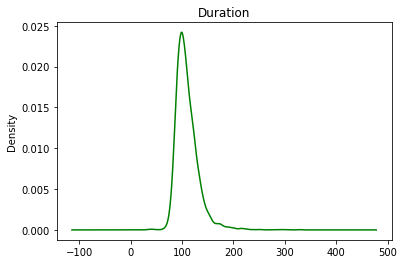

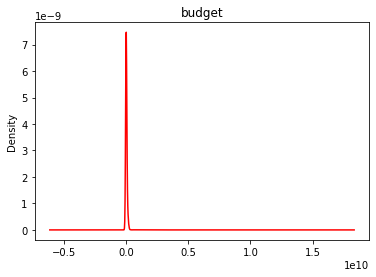

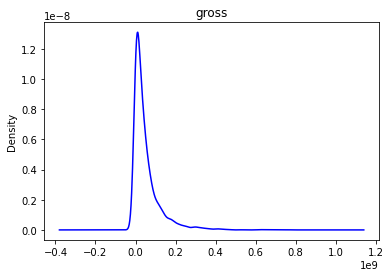

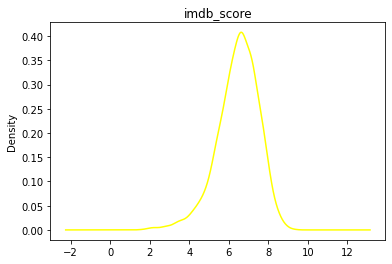

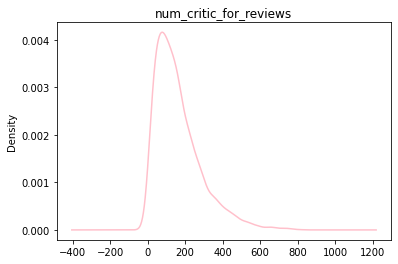

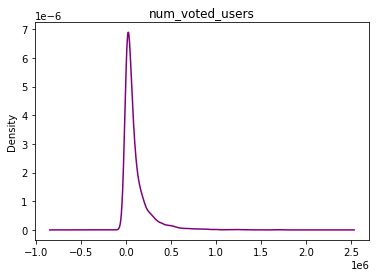

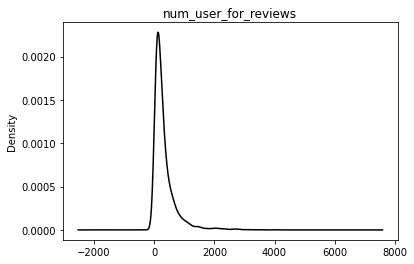

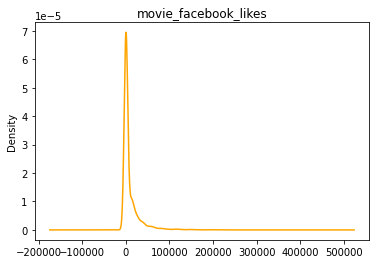

In [12]:

feature_table.duration.plot.density(color='green')
plt.title('Duration')
plt.show()
feature_table.budget.plot.density(color='red')
plt.title('budget')
plt.show()
feature_table.gross.plot.density(color='blue')
plt.title('gross')
plt.show()
feature_table.imdb_score.plot.density(color='yellow')
plt.title('imdb_score')
plt.show()
feature_table.num_critic_for_reviews.plot.density(color='pink')
plt.title('num_critic_for_reviews')
plt.show()
feature_table.num_voted_users.plot.density(color='purple')
plt.title('num_voted_users')
plt.show()
feature_table.num_user_for_reviews.plot.density(color='black')
plt.title('num_user_for_reviews')
plt.show()
feature_table.movie_facebook_likes.plot.density(color='orange')
plt.title('movie_facebook_likes')
plt.show()

<h2>Normaalverdeling meting:</h2>
TODO: wat doen we hiermee?

In [18]:
# Zoals hierboven te zien is aan de density plots, zijn niet alle feature variables normaal verdeelt
# Hier gebruiken we de normaltest waarmee scipy berekent of de gegeven data normaal verdeelt is.
# normal test geeft een pvalue. Als deze pvalue GROTER is dan 0.05, dan is de data normaal verdeelt.
print(stats.normaltest(feature_table['movie_facebook_likes']))
print(stats.normaltest(feature_table['duration']))
print(stats.normaltest(feature_table['gross']))
#Hier printen we de results van de normal test op kolomnen die visueel op een normaal verdeling lijken
# Hier blijkt dat geen van de kolomnen normaal verdeelt is.


#Hier laten we zien hoe we de outliers zouden verwijderen
#Dit doen we niet omdat de data niet normaal verdeelt is, waardoor de outliers ook niet veel zeggen
print(feature_table.count())
Q1 = feature_table.quantile(0.25)
Q3 = feature_table.quantile(0.75)
IQR = Q3 - Q1
no_out = feature_table.copy(deep=True)

no_out = no_out[~((no_out < (Q1 - 1.5 * IQR)) |(no_out > (Q3 + 1.5 * IQR))).any(axis=1)]
print(no_out.count())

NormaltestResult(statistic=3732.1533181284663, pvalue=0.0)
NormaltestResult(statistic=2134.319509049235, pvalue=0.0)
NormaltestResult(statistic=2616.9962246413447, pvalue=0.0)
movie_title               3889
duration                  3889
imdb_title_id             3889
num_voted_users           3889
num_critic_for_reviews    3889
num_user_for_reviews      3889
imdb_score                3889
movie_facebook_likes      3889
budget                    3889
gross                     3889
director_name             3889
dtype: int64
movie_title               2871
duration                  2871
imdb_title_id             2871
num_voted_users           2871
num_critic_for_reviews    2871
num_user_for_reviews      2871
imdb_score                2871
movie_facebook_likes      2871
budget                    2871
gross                     2871
director_name             2871
dtype: int64


C:\Users\LeviV\AppData\Local\Temp/ipykernel_17664/2822587936.py:19: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  no_out = no_out[~((no_out < (Q1 - 1.5 * IQR)) |(no_out > (Q3 + 1.5 * IQR))).any(axis=1)]


<h2>Conclusie density plots/outliers</h2>
TODO

<h1> Korte data-analyse </h1>

Hieronder doen we een aantal visualisaties om alvast wat inzicht te krijgen in eventuele correlaties tussen de data. Dit geeft een beetje en idee van hoe de data eruit ziet.

<h2> Correlatie IMDb Score vs Gross </h2>
Hier maken we een scatterplot om alvast te kijken naar de verhouding tussen imdb score en gross.

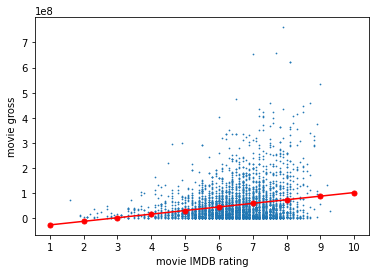

In [6]:
table = table.dropna()

x = table[['imdb_score']]
y = table[['gross']]

plt.xlabel('movie IMDB rating')
plt.ylabel('movie gross')

lm = linear_model.LinearRegression()
lm.fit(x, y)


pX = pd.DataFrame([1,2,3,4,5,6,7,8,9,10])


plt.plot([1,2,3,4,5,6,7,8,9,10],lm.predict(pX),
        marker='.', markerfacecolor='red', markersize=10, color = 'red')
plt.xticks(np.arange(0, 11, 1.0))


plt.scatter(x, y, s = .5)
plt.show()

Je kunt hier zien dat er zeker een correlatie te vinden is en dus is het interessant om verder te onderzoeken hoe zich dit verhoudt en of we dit kunnen gebruiken om voorspellingen te doen.

<h2> Correlatie facebook likes vs Gross</h2>
Hier zien we dat de correlatie tussen facebook likes en gross er heel anders uit ziet. Ook interessant om nader te onderzoeken.

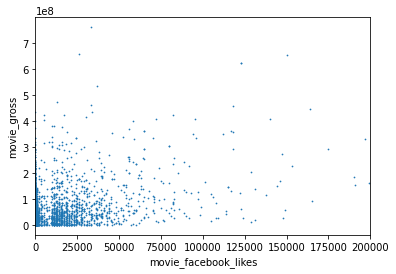

In [7]:
table = table.dropna()

x = table[['movie_facebook_likes']]
y = table[['gross']]

plt.xlabel('movie_facebook_likes')
plt.ylabel('movie_gross')


lm = linear_model.LinearRegression()
lm.fit(x, y)
plt.xlim(0,200000)

plt.scatter(x, y, s = .5)
plt.show()

<h2> Correlatie IMDb score vs Budget </h2>

Hier kijken we naar de correlatie tussen de IMDb score en het budget van de film. Er is duidelijk een lineare correlatie te herkennen.

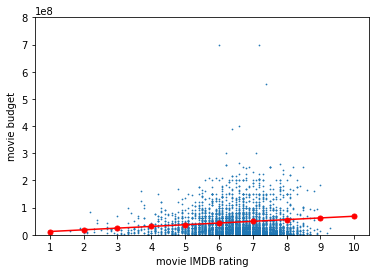

In [8]:
table = table.dropna()

x = table[['imdb_score']]
y = table[['budget']]

plt.xlabel('movie IMDB rating')
plt.ylabel('movie budget')


plt.ylim(0,800000000)

lm = linear_model.LinearRegression()
lm.fit(x, y)


pX = pd.DataFrame([1,2,3,4,5,6,7,8,9,10])


plt.plot([1,2,3,4,5,6,7,8,9,10],lm.predict(pX),
        marker='.', markerfacecolor='red', markersize=10, color = 'red')
plt.xticks(np.arange(0, 11, 1.0))


plt.scatter(x, y, s = .5)
plt.show()

In [ ]:
# Zoals hierboven te zien is aan de density plots, zijn niet alle feature variables normaal verdeelt
# Hier gebruiken we de normaltest waarmee scipy berekent of de gegeven data normaal verdeelt is.
# normal test geeft een pvalue. Als deze pvalue GROTER is dan 0.05, dan is de data normaal verdeelt.
print(stats.normaltest(templist['movie_facebook_likes']))
print(stats.normaltest(templist['duration']))
print(stats.normaltest(templist['gross']))
#Hier printen we de results van de normal test op kolomnen die visueel op een normaal verdeling lijken
# Hier blijkt dat geen van de kolomnen normaal verdeelt is.


#Hier laten we zien hoe we de outliers zouden verwijderen
#Dit doen we niet omdat de data niet normaal verdeelt is, waardoor de outliers ook niet veel zeggen
print(templist.count())
Q1 = templist.quantile(0.25)
Q3 = templist.quantile(0.75)
IQR = Q3 - Q1
no_out = templist.copy(deep=True)

no_out = no_out[~((no_out < (Q1 - 1.5 * IQR)) |(no_out > (Q3 + 1.5 * IQR))).any(axis=1)]
print(no_out.count())

<h2> Correlatie IMDb score vs Budget </h2>

Hier kijken we naar de correlatie tussen de IMDb score en het budget van de film. Er is duidelijk een lineare correlatie te herkennen.

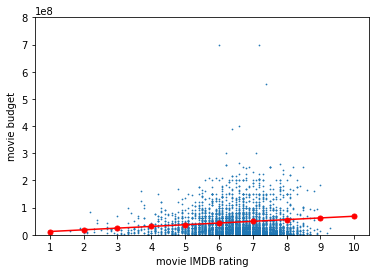

In [16]:
table = table.dropna()

x = table[['imdb_score']]
y = table[['budget']]

plt.xlabel('movie IMDB rating')
plt.ylabel('movie budget')


plt.ylim(0,800000000)

lm = linear_model.LinearRegression()
lm.fit(x, y)


pX = pd.DataFrame([1,2,3,4,5,6,7,8,9,10])


plt.plot([1,2,3,4,5,6,7,8,9,10],lm.predict(pX),
        marker='.', markerfacecolor='red', markersize=10, color = 'red')
plt.xticks(np.arange(0, 11, 1.0))


plt.scatter(x, y, s = .5)
plt.show()

<h2> Table merge process </h2>



Voor dit project hebben wij een tweede dataset gevonden op Kaggle (https://www.kaggle.com/stefanoleone992/imdb-extensive-dataset) met IMDb data. Die gaan we in het onderstaande codeblock samenvoegen met de gegeven database.

Daarvoor moeten we een aantal dingen doen. De eerste stap is om in de 2e tabel de kolom "movie_facebook_likes" toe te voegen en te vullen met NaNs, dat maakt het samenvoegen van de twee tabellen makkelijker.

Vervolgens zorgen we ervoor dat beide tabellen voor dezelfde informatie ook dezelfde colomnamen gebruiken. 

We gebruiken de IMDb ID als index. In de gegeven database is dit een ID, maar in onze database is het een link waar de ID in zit. Die trimmen we om de ID te extraheren. 

Als we dat hebben gedaan voegen we de twee databases samen en verwijderen dubbele waardes.

In [ ]:
def normalize_budget_gross():
    """the budget/gross of the second dataset uses a different format, we only keep the values already in USD"""

    def isnumber(x):
        try:
            float(x)
            return x
        except:
            return np.NaN

    table2['budget'] = table2['budget'].str.replace('$', '')
    table2['usa_gross_income'] = table2['usa_gross_income'].str.replace('$', '')

    table2['budget'] = table2['budget'].map(isnumber)

normalize_budget_gross()



#replace movie_facebook_likes that has 0 with NaN, since no movie actually has 0 facebook likes
table['movie_facebook_likes'] =  table['movie_facebook_likes'].replace(0, np.NaN)

In [ ]:
# the second data set has no facebook_likes so we create an empty column
table2['movie_facebook_likes'] = np.NaN

#trim both tables so we only have 
feature_table = table[['movie_title','duration', 'movie_imdb_link', 'num_voted_users', 'num_critic_for_reviews', 'num_user_for_reviews','imdb_score', 'movie_facebook_likes','budget', 'gross', 'director_name']]
feature_table2 = table2[['original_title', 'duration', 'imdb_title_id', 'votes', 'reviews_from_critics', 'reviews_from_users', 'avg_vote','movie_facebook_likes', 'budget','usa_gross_income', 'director' ]]


# change the movie_imdb_link to a imdb_title_id
feature_table["movie_imdb_link"]= feature_table["movie_imdb_link"].str.split("/", n = 5, expand = True)[4]
feature_table = feature_table.rename(columns={"movie_imdb_link": "imdb_title_id"})

#change the names of the columns of the second table to corresponding collumn names of the first table
feature_table2 = feature_table2.rename(columns={"avg_vote": "imdb_score", 'original_title':'movie_title', 'votes':'num_voted_users', 'usa_gross_income':'gross', 'reviews_from_critics': 'num_critic_for_reviews', 'reviews_from_users': 'num_user_for_reviews', 'director':'director_name'})

#append table2 to table
new_df = feature_table.append(feature_table2)

#remove duplicates from the merged tables
new_df.drop_duplicates(subset ="imdb_title_id",
                     keep = 'first', inplace = True)

# the gross and budget in the second table are in a different format so we need to come up with something to fix those
#set([str(x)[0] for x in new_df['gross']]) 
forbidden_chars = ['G', 'I', 'N', 'P', 'n']
new_df